# Parallel ViT-CNN Hybrid with HAM10000

## GPU Availability Check

We start with GPU availability check.

In [1]:
import tensorflow as tf
import torch

print(f"Tensorflow Version: {tf.__version__}")
print(f"TF GPU Available: {tf.config.list_physical_devices('GPU')}")

print(f"\nPyTourch Version: {torch.__version__}")
print(f"PyTourch GPU Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Device Name: {torch.cuda.get_device_name(0)}")

Tensorflow Version: 2.20.0
TF GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

PyTourch Version: 2.10.0+cu128
PyTourch GPU Available: True
Device Name: NVIDIA GeForce RTX 4070 Laptop GPU


## Dataset loading

We define the HAM10000 dataset,

In [2]:
import os
import pandas as pd
import torch
from PIL import Image
from torch.utils.data import Dataset
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder

class HAM10000Manager:
    def __init__(self, csv_file, img_dir):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir

        # 1. Encode Labels
        self.encoder = LabelEncoder()
        self.df['label'] = self.encoder.fit_transform(self.df['dx'])

        # 2. Map image IDs to actual file paths
        self.image_paths = {os.path.splitext(f)[0]: os.path.join(img_dir, f)
                           for f in os.listdir(img_dir)}

    def get_splits(self, train_size=0.8, val_size=0.1, test_size=0.1):
        """
        Splits data using lesion_id to prevent data leakage.
        """
        # First split: Train vs (Val + Test)
        gss_main = GroupShuffleSplit(n_splits=1, train_size=train_size, random_state=42)
        train_idx, temp_idx = next(gss_main.split(self.df, groups=self.df['lesion_id']))

        train_df = self.df.iloc[train_idx]
        temp_df = self.df.iloc[temp_idx]

        # Second split: Val vs Test from the remaining data
        # Calculate relative size: 0.1 / (0.1 + 0.1) = 0.5
        relative_val_size = val_size / (val_size + test_size)
        gss_val = GroupShuffleSplit(n_splits=1, train_size=relative_val_size, random_state=42)
        val_idx, test_idx = next(gss_val.split(temp_df, groups=temp_df['lesion_id']))

        val_df = temp_df.iloc[val_idx]
        test_df = temp_df.iloc[test_idx]

        return train_df, val_df, test_df

class HAM10000Dataset(Dataset):
    def __init__(self, dataframe, image_path_map, transform=None):
        self.df = dataframe
        self.image_paths = image_path_map
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = self.df.iloc[idx]['image_id']
        img_path = self.image_paths[img_id]
        image = Image.open(img_path).convert('RGB')
        label = self.df.iloc[idx]['label']

        if self.transform:
            image = self.transform(image)

        return image, label

.. and define custom resize transformation,

In [3]:
from torchvision import transforms
import torchvision.transforms.functional as F

class LetterboxResize:
    def __init__(self, target_size=(224, 224)):
        self.target_size = target_size

    def __call__(self, img):
        # 1. Resize the image such that the longest side matches target_size
        w, h = img.size
        max_side = max(self.target_size)
        scale = max_side / max(w, h)
        new_w, new_h = int(w * scale), int(h * scale)
        img = F.resize(img, (new_h, new_w))

        # 2. Pad the shorter side to make it square
        delta_w = self.target_size[0] - new_w
        delta_h = self.target_size[1] - new_h
        padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))

        # Use a constant background color (black or gray)
        return F.pad(img, padding, fill=0, padding_mode='constant')

.. and from such definition, we instantiate datasets.

In [4]:
from torchvision import transforms
from torch.utils.data import DataLoader

# Initialize Manager
manager = HAM10000Manager('/tf/data/ham10k/metadata.csv', '/tf/data/hams10k/images')
train_df, val_df, test_df = manager.get_splits()

# Define Transforms
train_transform = transforms.Compose([
    LetterboxResize(target_size=(224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create Dataset Objects
train_ds = HAM10000Dataset(train_df, manager.image_paths, transform=train_transform)
val_ds = HAM10000Dataset(val_df, manager.image_paths, transform=val_test_transform)
test_ds = HAM10000Dataset(test_df, manager.image_paths, transform=val_test_transform)

# Create Loaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

print(f"Train size: {len(train_ds)} | Val size: {len(val_ds)} | Test size: {len(test_ds)}")

Train size: 7991 | Val size: 1025 | Test size: 999


## Training

We define training step,

In [5]:
import torch
import torch.nn as nn
from tqdm import tqdm

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        # Conformer outputs: [logits_cnn, logits_trans]
        out_cnn, out_trans = model(images)

        # Combined loss as suggested in Conformer paper
        loss = criterion(out_cnn, labels) + criterion(out_trans, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # For accuracy, we usually average the predictions or use the transformer head
        prediction = (out_cnn + out_trans).argmax(dim=1)
        correct += (prediction == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(loader), 100 * correct / total

.. and validation step,

In [6]:
import torch
import torch.nn as nn
from tqdm import tqdm 

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)

            out_cnn, out_trans = model(images)
            loss = criterion(out_cnn, labels) + criterion(out_trans, labels)

            total_loss += loss.item()
            prediction = (out_cnn + out_trans).argmax(dim=1)
            correct += (prediction == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(loader), 100 * correct / total

.. silence warning

In [7]:
import warnings
warnings.filterwarnings("ignore")

.. and perform training

In [8]:
import torch
import torch.nn as nn
from tqdm import tqdm

import sys
import os

# Get the absolute path to your Conformer folder
path_to_conformer = os.path.abspath('./Conformer')

# Add it to the system path
if path_to_conformer not in sys.path:
    sys.path.insert(0, path_to_conformer)

from models import Conformer_small_patch16

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Conformer_small_patch16(num_classes=7).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
epoch_number = 20

best_val_acc = 0.0

for epoch in range(epoch_number):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc = validate(model, val_loader, criterion, DEVICE)

    print(f"Epoch {epoch}:")
    print(f"  Train Loss: {train_loss:.4f} | Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_conformer_ham.pth')
        print("  --> Model Checkpointed!")

Training: 100% 250/250 [15:18<00:00,  3.67s/it]
Validating: 100% 33/33 [00:18<00:00,  1.83it/s]


Epoch 0:
  Train Loss: 1.9043 | Acc: 67.88%
  Val Loss:   1.8969 | Acc: 68.20%
  --> Model Checkpointed!


Training: 100% 250/250 [14:46<00:00,  3.55s/it]
Validating: 100% 33/33 [00:16<00:00,  2.05it/s]


Epoch 1:
  Train Loss: 1.6412 | Acc: 70.44%
  Val Loss:   1.7800 | Acc: 67.61%


Training: 100% 250/250 [14:47<00:00,  3.55s/it]
Validating: 100% 33/33 [00:16<00:00,  2.06it/s]


Epoch 2:
  Train Loss: 1.5394 | Acc: 71.96%
  Val Loss:   1.7727 | Acc: 70.44%
  --> Model Checkpointed!


Training: 100% 250/250 [14:46<00:00,  3.55s/it]
Validating: 100% 33/33 [00:16<00:00,  2.03it/s]


Epoch 3:
  Train Loss: 1.4627 | Acc: 73.68%
  Val Loss:   1.7763 | Acc: 68.29%


Training: 100% 250/250 [14:47<00:00,  3.55s/it]
Validating: 100% 33/33 [00:16<00:00,  2.02it/s]


Epoch 4:
  Train Loss: 1.4165 | Acc: 74.51%
  Val Loss:   1.7877 | Acc: 69.07%


Training: 100% 250/250 [14:45<00:00,  3.54s/it]
Validating: 100% 33/33 [00:15<00:00,  2.13it/s]


Epoch 5:
  Train Loss: 1.3552 | Acc: 75.22%
  Val Loss:   1.6965 | Acc: 70.63%
  --> Model Checkpointed!


Training: 100% 250/250 [14:45<00:00,  3.54s/it]
Validating: 100% 33/33 [00:15<00:00,  2.06it/s]


Epoch 6:
  Train Loss: 1.3388 | Acc: 76.01%
  Val Loss:   1.5514 | Acc: 73.27%
  --> Model Checkpointed!


Training: 100% 250/250 [14:46<00:00,  3.55s/it]
Validating: 100% 33/33 [00:15<00:00,  2.07it/s]


Epoch 7:
  Train Loss: 1.2922 | Acc: 76.59%
  Val Loss:   1.7020 | Acc: 70.44%


Training: 100% 250/250 [14:46<00:00,  3.54s/it]
Validating: 100% 33/33 [00:15<00:00,  2.07it/s]


Epoch 8:
  Train Loss: 1.2614 | Acc: 77.02%
  Val Loss:   1.6124 | Acc: 72.39%


Training: 100% 250/250 [14:45<00:00,  3.54s/it]
Validating: 100% 33/33 [00:15<00:00,  2.09it/s]


Epoch 9:
  Train Loss: 1.2338 | Acc: 77.74%
  Val Loss:   1.7441 | Acc: 69.07%


Training: 100% 250/250 [14:45<00:00,  3.54s/it]
Validating: 100% 33/33 [00:15<00:00,  2.11it/s]


Epoch 10:
  Train Loss: 1.2081 | Acc: 78.64%
  Val Loss:   1.4949 | Acc: 74.93%
  --> Model Checkpointed!


Training: 100% 250/250 [14:46<00:00,  3.55s/it]
Validating: 100% 33/33 [00:15<00:00,  2.08it/s]


Epoch 11:
  Train Loss: 1.1643 | Acc: 79.24%
  Val Loss:   1.4844 | Acc: 74.93%


Training: 100% 250/250 [14:45<00:00,  3.54s/it]
Validating: 100% 33/33 [00:16<00:00,  2.02it/s]


Epoch 12:
  Train Loss: 1.1537 | Acc: 79.28%
  Val Loss:   1.5116 | Acc: 72.29%


Training: 100% 250/250 [14:46<00:00,  3.55s/it]
Validating: 100% 33/33 [00:15<00:00,  2.08it/s]


Epoch 13:
  Train Loss: 1.1103 | Acc: 80.45%
  Val Loss:   1.6120 | Acc: 72.49%


Training: 100% 250/250 [14:45<00:00,  3.54s/it]
Validating: 100% 33/33 [00:15<00:00,  2.10it/s]


Epoch 14:
  Train Loss: 1.0854 | Acc: 80.63%
  Val Loss:   1.7637 | Acc: 71.80%


Training: 100% 250/250 [14:46<00:00,  3.54s/it]
Validating: 100% 33/33 [00:15<00:00,  2.08it/s]


Epoch 15:
  Train Loss: 1.0587 | Acc: 81.67%
  Val Loss:   1.4647 | Acc: 74.93%


Training: 100% 250/250 [14:45<00:00,  3.54s/it]
Validating: 100% 33/33 [00:16<00:00,  2.05it/s]


Epoch 16:
  Train Loss: 1.0304 | Acc: 82.12%
  Val Loss:   1.5371 | Acc: 75.32%
  --> Model Checkpointed!


Training: 100% 250/250 [14:45<00:00,  3.54s/it]
Validating: 100% 33/33 [00:15<00:00,  2.08it/s]


Epoch 17:
  Train Loss: 1.0183 | Acc: 82.07%
  Val Loss:   1.5028 | Acc: 74.73%


Training: 100% 250/250 [14:45<00:00,  3.54s/it]
Validating: 100% 33/33 [00:16<00:00,  2.04it/s]


Epoch 18:
  Train Loss: 0.9808 | Acc: 82.49%
  Val Loss:   1.4581 | Acc: 75.41%
  --> Model Checkpointed!


Training: 100% 250/250 [14:45<00:00,  3.54s/it]
Validating: 100% 33/33 [00:15<00:00,  2.09it/s]


Epoch 19:
  Train Loss: 0.9536 | Acc: 83.74%
  Val Loss:   1.4637 | Acc: 75.80%
  --> Model Checkpointed!


## Evaluation

We evaluate model by plotting confusion matrix,

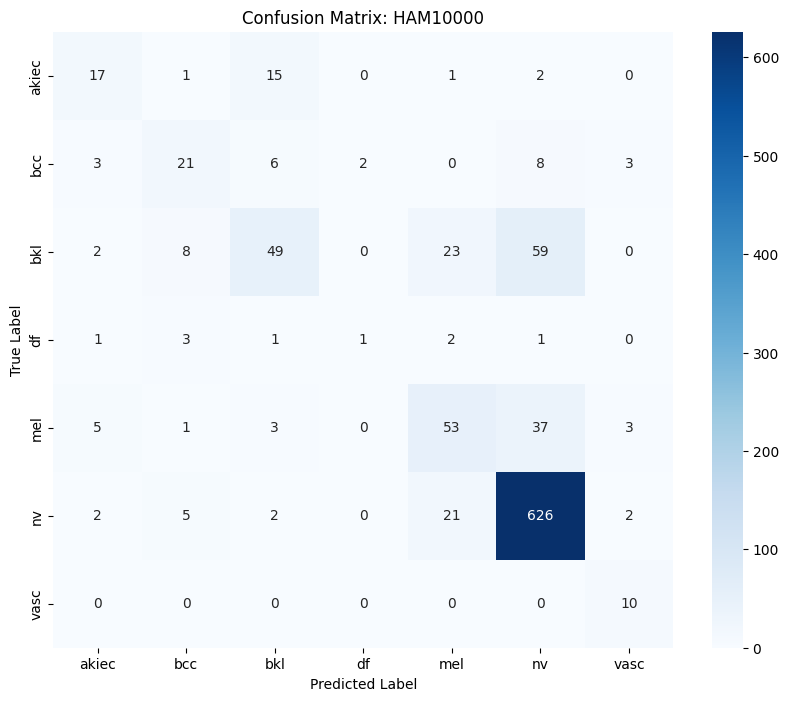


Classification Report:

              precision    recall  f1-score   support

       akiec       0.57      0.47      0.52        36
         bcc       0.54      0.49      0.51        43
         bkl       0.64      0.35      0.45       141
          df       0.33      0.11      0.17         9
         mel       0.53      0.52      0.52       102
          nv       0.85      0.95      0.90       658
        vasc       0.56      1.00      0.71        10

    accuracy                           0.78       999
   macro avg       0.57      0.56      0.54       999
weighted avg       0.76      0.78      0.76       999



In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(model, loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)

            # Conformer dual-output handling: average the branches for prediction
            out_cnn, out_trans = model(images)
            outputs = (out_cnn + out_trans) / 2

            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate the matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plotting
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix: HAM10000')
    plt.show()

    # Also print the detailed F1-score/Recall report
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

# Usage:
# Get names from the encoder we defined in the Manager class
class_names = manager.encoder.classes_
plot_confusion_matrix(model, test_loader, DEVICE, class_names)

.. also plot PR-curve,

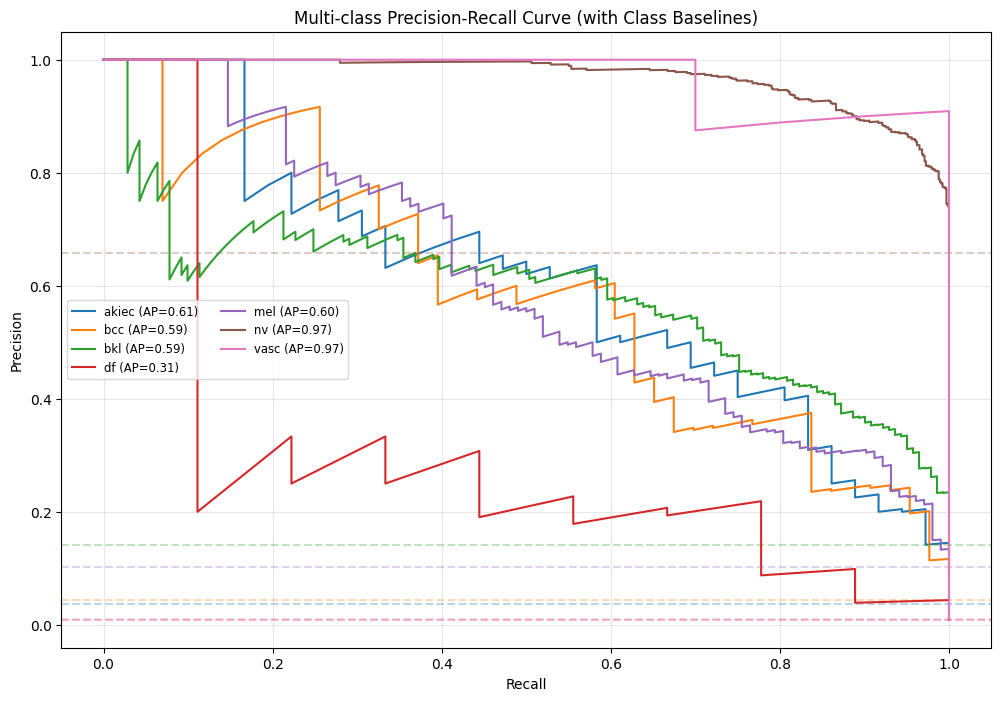

In [10]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

def plot_pr_curve(model, loader, device, class_names):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            out_cnn, out_trans = model(images)
            # Use averaged probabilities for the curve
            probs = torch.softmax((out_cnn + out_trans) / 2, dim=1)

            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.numpy())

    Y_test = label_binarize(np.concatenate(all_labels), classes=range(len(class_names)))
    Y_score = np.concatenate(all_probs)
    n_classes = len(class_names)

    plt.figure(figsize=(12, 8))

    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(Y_test[:, i], Y_score[:, i])
        ap_score = average_precision_score(Y_test[:, i], Y_score[:, i])

        # Calculate baseline (prevalence of class i)
        baseline = np.sum(Y_test[:, i]) / len(Y_test)

        line, = plt.plot(recall, precision, label=f'{class_names[i]} (AP={ap_score:.2f})')
        # Draw dashed baseline with the same color as the curve
        plt.axhline(y=baseline, color=line.get_color(), linestyle='--', alpha=0.3)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Multi-class Precision-Recall Curve (with Class Baselines)')
    plt.legend(loc='best', fontsize='small', ncol=2)
    plt.grid(alpha=0.3)
    plt.show()

# Usage:
plot_pr_curve(model, test_loader, DEVICE, manager.encoder.classes_)

.. and AUC PR

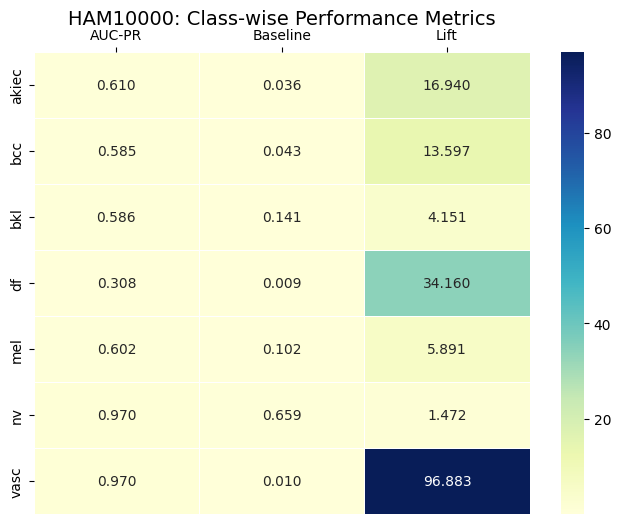

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

def plot_styled_auc_table(model, loader, device, class_names):
    model.eval()
    all_probs, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            out_cnn, out_trans = model(images)
            probs = torch.softmax((out_cnn + out_trans) / 2, dim=1)
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.numpy())

    Y_test = label_binarize(np.concatenate(all_labels), classes=range(len(class_names)))
    Y_score = np.concatenate(all_probs)

    # 1. Generate Metrics
    data = []
    for i, name in enumerate(class_names):
        auc_pr = average_precision_score(Y_test[:, i], Y_score[:, i])
        baseline = np.sum(Y_test[:, i]) / len(Y_test)
        lift = auc_pr / baseline if baseline > 0 else 0
        data.append([auc_pr, baseline, lift])

    # 2. Create DataFrame for Seaborn
    df_metrics = pd.DataFrame(data, index=class_names, columns=['AUC-PR', 'Baseline', 'Lift'])

    # 3. Plotting
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_metrics, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True, linewidths=.5)

    plt.title('HAM10000: Class-wise Performance Metrics', pad=20, fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=True, labeltop=True)
    plt.show()

# Usage
plot_styled_auc_table(model, test_loader, DEVICE, manager.encoder.classes_)

## Explanation

Let's try to explain how our model works.

We start with explaining how CNN branch works with Grad-CAM,

Automatically targeted layer: Conv2d(384, 256, kernel_size=(1, 1), stride=(1, 1))
True Class: bkl | Predicted Class: bkl


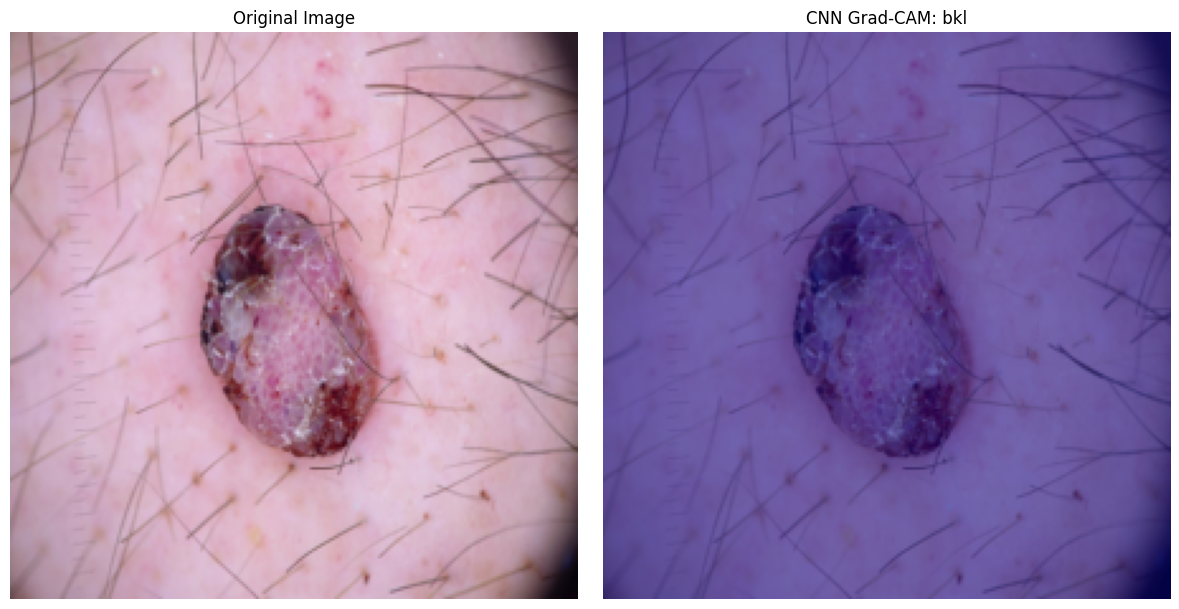

In [12]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image

class CNN_GradCAM:
    def __init__(self, model, target_layer=None):
        self.model = model
        self.model.eval()
        self.features = None
        self.gradients = None

        # Automatically find the last Conv2d layer if not specified
        if target_layer is None:
            target_layer = self._find_last_conv_layer()
            print(f"Automatically targeted layer: {target_layer}")

        # Register hooks
        self._register_hooks(target_layer)

    def _find_last_conv_layer(self):
        # Heuristic to find the last Conv2d layer (usually part of the CNN block)
        last_conv = None
        for name, module in self.model.named_modules():
            if isinstance(module, torch.nn.Conv2d):
                last_conv = module
        return last_conv

    def _register_hooks(self, layer):
        def forward_hook(module, input, output):
            self.features = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        layer.register_forward_hook(forward_hook)
        layer.register_full_backward_hook(backward_hook)

    def generate_cam(self, input_image, target_class=None):
        # 1. Forward Pass
        self.model.zero_grad()
        # Conformer specific: Unpack the tuple
        out_cnn, out_trans = self.model(input_image)

        # 2. Select Target
        if target_class is None:
            # Determine class based on combined logic
            final_pred = (out_cnn + out_trans).argmax(dim=1)
            target_class = final_pred.item()

        # 3. Backward Pass on CNN Output ONLY
        score = out_cnn[0, target_class]
        score.backward()

        # 4. Generate Grad-CAM weights
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)

        # Weighted combination of feature maps
        cam = torch.sum(weights * self.features, dim=1, keepdim=True)

        # Apply ReLU
        cam = F.relu(cam)

        # Normalize to 0-1
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-7)

        return cam.cpu().detach().numpy()[0, 0], target_class

def visualize_cam(original_img_tensor, cam_mask, class_name):
    """
    Visualizes Grad-CAM using PIL and Matplotlib (No OpenCV).
    """
    # 1. Convert tensor to numpy image (H, W, C)
    img = original_img_tensor.cpu().numpy().transpose(1, 2, 0)

    # 2. Denormalize (assuming ImageNet means/stds)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    # 3. Resize CAM to match Original Image using PIL
    # Scale CAM to 0-255 uint8 for PIL processing
    cam_uint8 = np.uint8(255 * cam_mask)
    cam_pil = Image.fromarray(cam_uint8, 'L') # 'L' mode for grayscale

    # Upsample using Bicubic interpolation
    original_h, original_w = img.shape[:2]
    cam_pil_resized = cam_pil.resize((original_w, original_h), resample=Image.BICUBIC)

    # Convert back to numpy float 0-1
    cam_resized = np.array(cam_pil_resized) / 255.0

    # 4. Apply Colormap (Jet) using Matplotlib
    # cm.jet returns (H, W, 4) RGBA, we only need RGB
    heatmap = cm.jet(cam_resized)[..., :3]

    # 5. Superimpose
    alpha = 0.5
    overlay = (1 - alpha) * img + alpha * heatmap
    overlay = np.clip(overlay, 0, 1)

    # 6. Plotting
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(img)
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    ax[1].imshow(overlay)
    ax[1].set_title(f"CNN Grad-CAM: {class_name}")
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

# --- Example Usage Logic ---
# (Assumes 'model', 'test_loader', 'DEVICE', and 'class_names' are defined from previous cells)

# 1. Instantiate the CAM object
# We let it auto-find the last conv layer in the CNN branch
grad_cam = CNN_GradCAM(model)

# 2. Get a sample image
img_tensor, label = next(iter(test_loader))
input_image = img_tensor[0].unsqueeze(0).to(DEVICE)
true_class_name = manager.encoder.classes_[label[0].item()]

# 3. Generate CAM
mask, pred_class_idx = grad_cam.generate_cam(input_image)
pred_class_name = manager.encoder.classes_[pred_class_idx]

# 4. Visualize
print(f"True Class: {true_class_name} | Predicted Class: {pred_class_name}")
visualize_cam(input_image[0], mask, pred_class_name)

.. the we explain transformer with Attention Rollout,

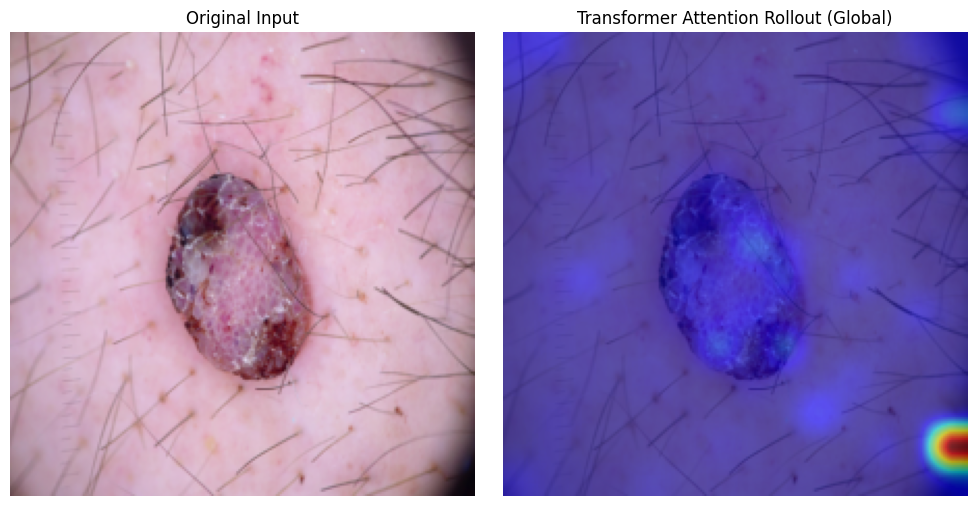

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image

class ConformerRollout:
    def __init__(self, model):
        self.model = model
        self.attentions = []
        self.hooks = []

    def _get_attn_hook(self):
        def hook(module, input, output):
            # The input to the dropout layer in a standard ViT Attention block
            # is the attention matrix (Batch, Heads, Tokens, Tokens)
            # We capture input[0] because input is a tuple
            self.attentions.append(input[0].detach().cpu())
        return hook

    def register_hooks(self):
        """
        Recursively finds all 'attn_drop' modules in the model (standard in timm/Conformer)
        and registers a forward hook to capture attention weights.
        """
        self.attentions = []
        self.hooks = []
        for name, module in self.model.named_modules():
            # 'attn_drop' is the standard name in the Conformer source code for
            # the dropout layer applied to the Softmax(Q@K) matrix.
            if "attn_drop" in name:
                self.hooks.append(module.register_forward_hook(self._get_attn_hook()))

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()
        self.hooks = []

    def generate_rollout(self, input_tensor, discard_ratio=0.9):
        """
        Computes the Attention Rollout mask.
        """
        self.register_hooks()

        # 1. Forward Pass
        self.model.eval()
        self.model.zero_grad()
        with torch.no_grad():
            # Handle potential tuple output from Conformer
            _ = self.model(input_tensor)

        self.remove_hooks()

        if not self.attentions:
            print("Error: No attention layers captured. Check layer names.")
            return None

        # 2. Compute Rollout
        # Start with Identity Matrix to represent residual connections
        # Shape: (Tokens, Tokens) matching the last layer
        num_tokens = self.attentions[0].size(-1)
        result = torch.eye(num_tokens)

        # Iterate from input layer to output layer
        for attn in self.attentions:
            # attn shape: (1, Heads, Tokens, Tokens)
            # We average attention weights across all heads
            attn_fused = attn.mean(axis=1)[0] # Shape: (Tokens, Tokens)

            # To account for Residual Connections in the Transformer Block (x + Attention(x)),
            # we add the Identity matrix and re-normalize.
            # Formula: A_hat = 0.5 * A + 0.5 * I
            attn_fused = attn_fused + torch.eye(attn_fused.size(0))
            attn_fused = attn_fused / attn_fused.sum(dim=-1, keepdim=True)

            # Recursive Multiplication: Rollout_l = A_l * Rollout_{l-1}
            result = torch.matmul(attn_fused, result)

        # 3. Extract Class Token Attention
        # The first token (index 0) is the CLS token. We want to see what pixels
        # it attended to.
        mask = result[0, 1:] # Drop index 0 (self-attention to CLS)

        # Reshape to 2D map
        # For 224x224 image and patch size 16, we expect 14x14 = 196 patches
        width = int(np.sqrt(mask.size(0)))
        mask = mask.reshape(width, width).numpy()

        # Normalize for visualization (0 to 1)
        mask = (mask - mask.min()) / (mask.max() - mask.min())
        return mask

def visualize_rollout(original_img_tensor, mask, alpha=0.6):
    """
    Visualizes Attention Rollout using PIL and Matplotlib (No OpenCV).
    """
    # 1. Convert tensor to numpy image (H, W, C)
    img = original_img_tensor.cpu().numpy().transpose(1, 2, 0)

    # 2. Denormalize (assuming ImageNet normalization used in the notebook)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    # 3. Resize mask to match image dimensions using PIL
    # Scale mask to 0-255 uint8
    mask_uint8 = np.uint8(255 * mask)
    mask_pil = Image.fromarray(mask_uint8, mode='L')

    # Resize using Bicubic interpolation for smooth heatmap
    original_h, original_w = img.shape[:2]
    mask_resized_pil = mask_pil.resize((original_w, original_h), resample=Image.BICUBIC)

    # Convert back to float 0-1
    mask_resized = np.array(mask_resized_pil) / 255.0

    # 4. Apply Colormap (Jet) using Matplotlib
    # cm.jet returns RGBA (H, W, 4), discard Alpha channel
    heatmap = cm.jet(mask_resized)[..., :3]

    # 5. Overlay
    overlay = (1 - alpha) * img + alpha * heatmap
    overlay = np.clip(overlay, 0, 1)

    # 6. Plotting
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(img)
    ax[0].set_title("Original Input")
    ax[0].axis('off')

    ax[1].imshow(overlay)
    ax[1].set_title("Transformer Attention Rollout (Global)")
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

img_tensor, label = next(iter(test_loader))
input_image = img_tensor[0].unsqueeze(0).to(DEVICE)

# 2. Instantiate and Run
rollout_explainer = ConformerRollout(model)
mask = rollout_explainer.generate_rollout(input_image)

# 3. Visualize
if mask is not None:
    visualize_rollout(input_image[0], mask)

.. adn then integrated gradient for holistic model explanation.

Computing Integrated Gradients... (this may take a moment)
Convergence Delta: 0.07038283348083496 (Lower is better)


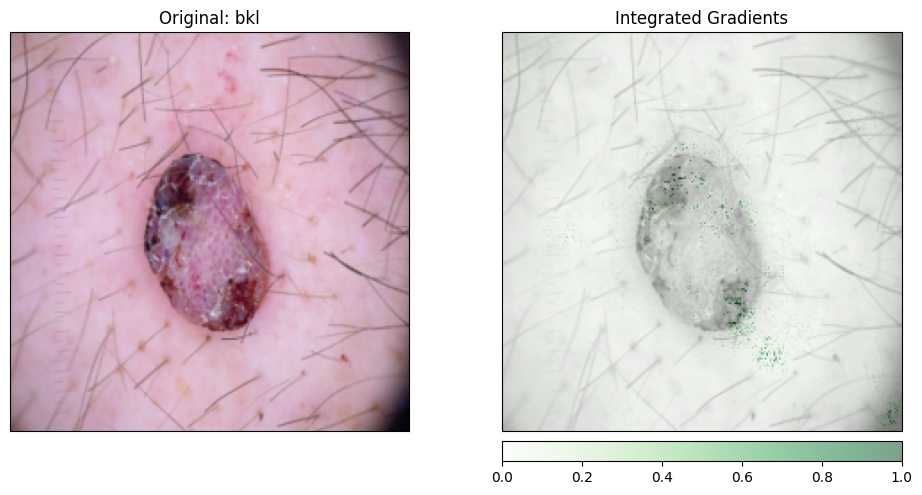

In [14]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz

class ConformerWrapper(nn.Module):
    """
    Wraps the Conformer to fuse the two branches into a single output.
    This ensures IG explains the actual decision mechanism.
    """
    def __init__(self, conformer_model):
        super(ConformerWrapper, self).__init__()
        self.model = conformer_model

    def forward(self, x):
        # 1. Forward pass through original model
        out_cnn, out_trans = self.model(x)

        # 2. Fuse outputs (Summation, as per notebook logic)
        return out_cnn + out_trans

def explain_with_ig(model, input_tensor, target_class_idx, class_names):
    """
    Computes and visualizes Integrated Gradients.
    """
    # 1. Wrap the model
    wrapped_model = ConformerWrapper(model)
    wrapped_model.eval()

    # 2. Initialize IG
    ig = IntegratedGradients(wrapped_model)

    # 3. Compute Attributions
    # We attribute the decision to the input pixels relative to a black baseline
    print("Computing Integrated Gradients... (this may take a moment)")
    attributions, delta = ig.attribute(
        input_tensor,
        target=target_class_idx,
        baselines=torch.zeros_like(input_tensor),
        n_steps=50, # Higher steps = more accurate approximation of the integral
        return_convergence_delta=True
    )

    print(f"Convergence Delta: {delta.item()} (Lower is better)")

    # 4. Prepare for Visualization
    # Transpose to (H, W, C) for Matplotlib
    attr_np = attributions[0].cpu().detach().numpy().transpose(1, 2, 0)
    img_np = input_tensor[0].cpu().detach().numpy().transpose(1, 2, 0)

    # Denormalize Image (Restoring original colors)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)

    # 5. Visualize
    # 'blended_heat_map' overlays the attribution on the image
    viz.visualize_image_attr_multiple(
        attr_np,
        img_np,
        methods=["original_image", "blended_heat_map"],
        signs=["all", "positive"],
        show_colorbar=True,
        titles=[f"Original: {class_names[target_class_idx]}", "Integrated Gradients"],
        fig_size=(10, 5)
    )

# 1. Get a single sample
img_tensor, label = next(iter(test_loader))
input_image = img_tensor[0].unsqueeze(0).to(DEVICE)
target_class = label[0].item()

# 2. Get class names (if available from manager)
try:
    class_names = manager.encoder.classes_
except:
    class_names = [f"Class {i}" for i in range(7)]

# 3. Run Explanation
explain_with_ig(model, input_image, target_class, class_names)